In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import modplot
import numpy as np
import ibu
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
#import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
import yaml
import json
import sys
itnum=5

In [1]:
def to_categorical(labels, num_classes=None):
    """One-hot encodes class labels.

    **Arguments**

    - **labels** : _1-d numpy.ndarray_
        - Labels in the range `[0,num_classes)`.
    - **num_classes** : {_int_, `None`}
        - The total number of classes. If `None`, taken to be the 
        maximum label plus one.

    **Returns**

    - _2-d numpy.ndarray_
        - The one-hot encoded labels.
    """

    # get num_classes from max label if None
    if num_classes is None:
        num_classes = int(np.max(labels)) + 1

    y = np.asarray(labels, dtype=int)
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))

    # index into array and set appropriate values to 1
    categorical[np.arange(n), y] = 1

    return categorical

In [6]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=1000000, exclude_keys=['particles']),
        'Herwig': ef.zjets_delphes.load('Herwig', num_data=1200000, exclude_keys=['particles'])}
synthetic, nature = datasets['Pythia26'], datasets['Herwig']


obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, ptype: np.log(dset[ptype + '_sdms']**2/
                                    dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
            'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}


# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                            density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                        ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
# 
    print('Done with', obkey)


Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


In [7]:
import pandas as pd
temp=np.asarray([obs[obkey]['simobs'] for obkey in obs_multifold]).T
Sim_particle=pd.DataFrame(temp)
#Sim_detector=pd.DataFrame(temp)\
efficiency=Sim_particle.sample(n=200000,random_state=30)
Sim_detector=Sim_particle.drop(efficiency.index)
event_particle=np.array(Sim_particle.index)
event_detector=np.array(Sim_detector.index)




common_events=np.where(np.isin(event_particle,np.intersect1d(event_detector,event_particle)))[0]
different_events=np.where(~np.isin(event_particle,np.intersect1d(event_detector,event_particle)))[0]



X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'][common_events])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['dataobs'])), 
                                            np.zeros(len(obs['Mass']['simobs'][common_events])) )))
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

X_diff = np.asarray([obs[obkey]['genobs'][different_events]for obkey in obs_multifold]).T

#Y_diff=ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['dataobs'][different_events])), 
#                                               np.zeros(len(obs['Mass']['simobs'][different_events])) )))

X_com = np.asarray([np.concatenate((obs[obkey]['genobs'][common_events], obs[obkey]['genobs'][common_events])) for obkey in obs_multifold]).T
Y_com=ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['genobs'][common_events])), 
                                            np.zeros(len(obs['Mass']['genobs'][common_events])) )))

X_gen= np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen=ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['genobs'])), 
                                            np.zeros(len(obs['Mass']['genobs'])) )))


In [8]:
sim_det=pd.DataFrame({obkey: obs[obkey]['simobs'] for obkey in obs_multifold})
sim_part=pd.DataFrame({obkey: obs[obkey]['genobs'] for obkey in obs_multifold})
data_det=pd.DataFrame({obkey: obs[obkey]['dataobs'] for obkey in obs_multifold})
data_part=pd.DataFrame({obkey: obs[obkey]['truthobs'] for obkey in obs_multifold})

sim_det['event']=np.array(sim_det.index)
sim_part['event']=np.array(sim_part.index)
data_det['event']=np.array(data_det.index)
data_part['event']=np.array(data_part.index)

In [9]:
temp=sim_det.sample(frac=0.3).index
sim_det=sim_det.drop(temp)

temp=sim_part.sample(frac=0.1).index
sim_part=sim_part.drop(temp)

In [10]:
len(sim_det)

700000

In [11]:
D=np.array(sim_det['event'])
P=np.array(sim_part['event'])    

In [12]:
full_set_events=np.unique(np.concatenate((D,P)))

In [13]:
common_events=np.intersect1d(D,P)
det_eff_events=np.setdiff1d(P,D)
neutrino_eff_events=np.setdiff1d(D,P)
particle_events=P

In [14]:
inputs = Input((8, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [15]:
X_det=np.asarray([np.concatenate((data_det[var],sim_det[var])) for var in obs_multifold]).T
Y_det=to_categorical(np.concatenate(( np.ones(len(data_det['Mass'])),
                                             np.zeros(len(sim_det['Mass']))   )))





X_gen=np.asarray([np.concatenate((sim_part[var],sim_part[var])) for var in obs_multifold]).T
Y_gen=to_categorical(np.concatenate(( np.ones(len(sim_part['Mass'])),
                                             np.zeros(len(sim_part['Mass']))   )))


ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [16]:
itnum=5
weights_push=np.ones(len(sim_part['Mass']))
weights_pull=np.ones(len(sim_part['Mass']))


input_det=pd.concat([pd.DataFrame(data_det[obs_multifold+['event']]),pd.DataFrame(sim_det[obs_multifold+['event']])])
input_det['target']=np.concatenate((np.ones(len(data_det)),np.zeros(len(sim_det))))
#input_det['w']=np.concatenate((np.ones(len(data_det)),winit*  sim_det['Event.Weight'])  )

input_gen=pd.concat([pd.DataFrame(sim_part[obs_multifold+['event']]),pd.DataFrame(sim_part[obs_multifold+['event']])])
input_gen['target']=np.concatenate((np.ones(len(sim_part)),np.zeros(len(sim_part))))
#input_gen['w']=np.concatenate((np.ones(len(sim_part)),np.ones(len(sim_part))))

inputs = Input((6, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)


weights_push=np.ones(len(full_set_events))
weights_pull=np.ones(len(full_set_events))

push_mapping=dict(zip(full_set_events,weights_push))
pull_mapping=dict(zip(full_set_events,weights_pull))



In [17]:
push_series=pd.Series(push_mapping)
pull_series=pd.Series(pull_mapping)

In [18]:
push_series.loc[D]=winit

In [19]:
len(input_det),len(push_series.loc[D])

(1900000, 700000)

In [20]:
for i in range(3):

    w1=np.concatenate((np.ones(len(data_det)),push_series.loc[D]))

    model_step1 = Model(inputs=inputs, outputs=outputs)
    X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(input_det[obs_multifold],
                                                                  input_det['target'],
                                                                  w1)
    
    model_step1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model_step1.fit(X_train,y_train,sample_weight=w_train,epochs=40,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)

    f=model_step1.predict(sim_det.loc[sim_det['event'].isin(common_events)][obs_multifold],batch_size=10000)
    temp=f/(1-f)
    temp=np.squeeze(np.nan_to_num(temp)) 

    pull_series.loc[common_events]=temp*push_series.loc[common_events]
    pull_series.loc[det_eff_events]=1
    
    



    #weights_pull=np.array(sim_part.loc[sim_part['event'].isin(common_events),'w'])*temp


    w2=np.concatenate((pull_series[P],push_series[P]))

    model_step2 = Model(inputs=inputs, outputs=outputs)

    X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(input_gen[obs_multifold],
                                                                  input_gen['target'],
                                                                  w2)
    
    model_step2.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model_step2.fit(X_train,y_train,sample_weight=w_train,epochs=40,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)


    
    f=model_step2.predict(sim_part[obs_multifold],batch_size=10000)
    temp=f/(1-f)
    temp=np.squeeze(np.nan_to_num(temp)) 

    
    push_series.loc[P]=temp*push_series[P]
    push_series.loc[neutrino_eff_events]=1



    
    



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [21]:
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = sim_part[obkey],sim_det[obkey]
    ob['truthobs'], ob['dataobs'] = data_part[obkey], data_det[obkey]
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                            density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    #ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    #ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
   #ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                    #    ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    #ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
# 
    print('Done with', obkey)


Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


1.3354230606551167


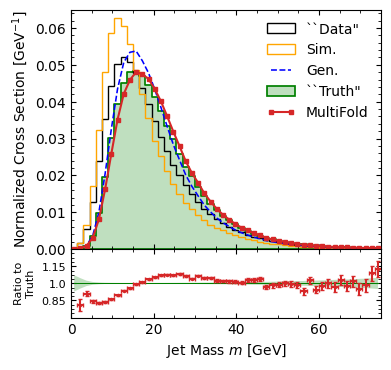

0.155599753563001


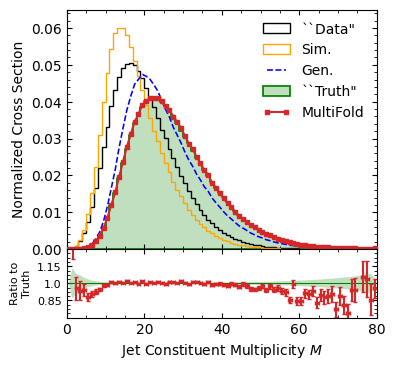

1.469805639632181


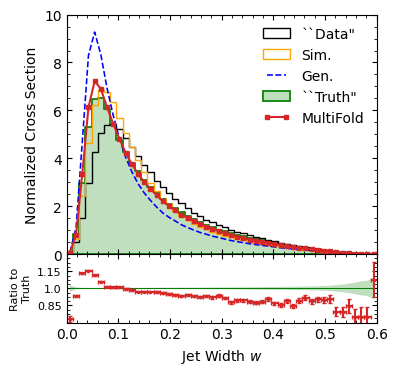

3.840199741270987


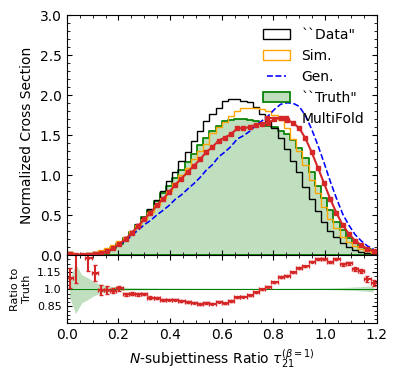

1.2655082342069162


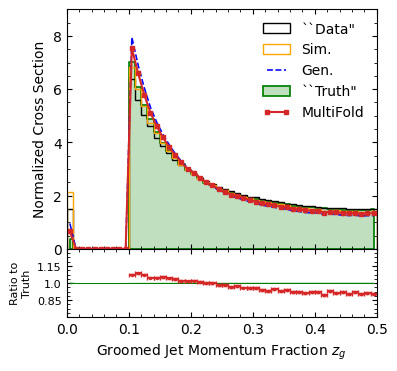

1.0829070586231786


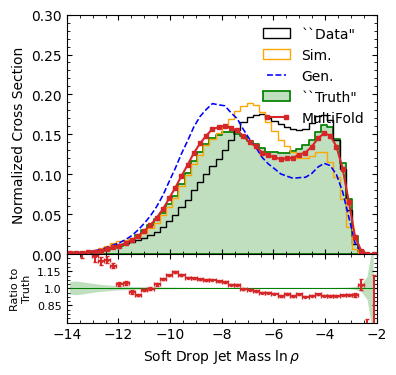

In [22]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=push_series.loc[P], 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # plot the IBU distribution
    #ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    #ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    #ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
    #                                          color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 5, 0, 1] if ncol==2 else [3, 5, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False,)# order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    #modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
    #              line_0=r'$\mathbf{D/T}: \mathtt{Herwig\  7.1.5}$ default',
    #              line_1=r'$\mathbf{S/G}: \mathtt{Pythia\ 8.243}$ tune 26',
    #              line_2=r'$\mathtt{Delphes 3.4.2}$ CMS Detector',
    #              line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    #print(np.sum( ((ob['truth_hist']-of_histgen)**2) / (ob['truth_hist']+of_histgen + 10**-50 )  )*1000/2     )
    bin_centres=(ob['midbins_mc'][1:]+ob['midbins_mc'][:-1])/2
    width=np.sum(ob['midbins_mc'][1:]-ob['midbins_mc'][:-1])/len(bin_centres)
    print(width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2)
    #ethod2_scores['epochs_20'].update({obkey:width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2})
    plt.show()